In [22]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon
latent_dim = 20

#Build the encoder
encoder_inputs = keras.Input(shape=(88, 1))
x = layers.Conv1D(8, 3, activation='relu', padding='same', dilation_rate=2)(encoder_inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(16, 3, activation='relu', padding='same', dilation_rate=2)(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Flatten()(x)
encoder = layers.Dense(128, activation='relu')(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(encoder)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(encoder)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

#Build the decoder
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(128, activation='relu')(latent_inputs)
x = layers.Dense(88 * 8)(x)
x = layers.Reshape((88, 8))(x)
x = layers.Conv1D(16, 3, activation='relu', padding='same')(x)
x = layers.UpSampling1D(2)(x)
x = layers.Conv1D(8, 3, activation='relu', padding='same')(x)
x = layers.UpSampling1D(2)(x)
decoded = layers.Conv1D(1, 3, activation='sigmoid', padding='same')(x)
decoded = layers.Cropping1D(cropping=(0, 264))(decoded)
decoder = keras.Model(latent_inputs, decoded, name="decoder")
decoder.summary()

class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum((data - reconstruction) ** 2, axis=(1, 2))
            )
            kl_loss = -0.0001 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }


    def test_step(self, data):
        x = data

        z_mean, z_log_var, z = self.encoder(x, training=False)
        reconstructed_x = self.decoder(z, training=False)

        reconstruction_loss = tf.reduce_mean(
            tf.reduce_sum((x - reconstructed_x) ** 2, axis=(1, 2))
        )

        kl_loss = -0.0001 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
        kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))

        total_loss = reconstruction_loss + kl_loss

        results = {m.name: m.result() for m in self.metrics}
        results["reconstruction_loss"] = reconstruction_loss
        results["kl_loss"] = kl_loss
        results["total_loss"] = total_loss
        return results


Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 88, 1)]      0           []                               
                                                                                                  
 conv1d_5 (Conv1D)              (None, 88, 8)        32          ['input_3[0][0]']                
                                                                                                  
 max_pooling1d_2 (MaxPooling1D)  (None, 44, 8)       0           ['conv1d_5[0][0]']               
                                                                                                  
 conv1d_6 (Conv1D)              (None, 44, 16)       400         ['max_pooling1d_2[0][0]']        
                                                                                            

In [23]:
from sklearn.preprocessing import MinMaxScaler

features = pd.read_csv('features.csv')
labels = pd.read_csv('labels.csv')
(x_train, x_test, y_train, y_test) = train_test_split(
                                    features, labels, test_size=0.2, random_state=42)

x_train_seq = x_train.values[:, 0]
x_test_seq = x_test.values[:, 0]

x_train_features = x_train.values[:, 1:]
x_test_features = x_test.values[:, 1:]

scaler = MinMaxScaler()

x_train = scaler.fit_transform(x_train_features)
x_test = scaler.transform(x_test_features)

x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
y_train = np.expand_dims(y_train, -1)
y_test = np.expand_dims(y_test, -1)

In [24]:
#learn_rate = [0.005, 0.01, 0.05, 0.1]
#batch_size = [32, 64, 128, 256]
learn_rate = [0.05, 0.1]
batch_size = [32, 64]

param_grid = dict(learn_rate=learn_rate, batch_size=batch_size)

best_score = None
best_params = {}

for lr in learn_rate:
    for bs in batch_size:
        
        vae = VAE(encoder, decoder)
        vae.compile(optimizer=keras.optimizers.Adam(learning_rate=lr))

        vae.fit(x_train, batch_size=bs, epochs=3)

        score = vae.evaluate(x_test)

        if best_score is None or score < best_score:
            best_score = score
            best_params = {'learn_rate': lr, 'batch_size': bs}

print("Best Hyperparameters:", best_params)
print("Best Score:", best_score)

lr = best_params['learn_rate']
bs = best_params['batch_size']

Epoch 1/3
262/262 [==============================] - 3s 6ms/step - loss: 1.8573 - reconstruction_loss: 1.7432 - kl_loss: 0.0020
Epoch 2/3
262/262 [==============================] - 1s 6ms/step - loss: 1.7095 - reconstruction_loss: 1.6952 - kl_loss: 0.0012
Epoch 3/3
66/66 [==============================] - 0s 2ms/step - total_loss: 1.7216 - reconstruction_loss: 1.7205 - kl_loss: 0.0012
Epoch 1/3
131/131 [==============================] - 3s 8ms/step - loss: 1.7052 - reconstruction_loss: 1.6943 - kl_loss: 0.0016
Epoch 2/3
131/131 [==============================] - 1s 8ms/step - loss: 1.6892 - reconstruction_loss: 1.6916 - kl_loss: 0.0017
Epoch 3/3
66/66 [==============================] - 0s 2ms/step - total_loss: 1.7150 - reconstruction_loss: 1.7126 - kl_loss: 0.0024
Epoch 1/3
262/262 [==============================] - 3s 6ms/step - loss: 1.7549 - reconstruction_loss: 1.7725 - kl_loss: 0.0028
Epoch 2/3
262/262 [==============================] - 2s 6ms/step - loss: 1.7962 - reconstruction

In [25]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam(learning_rate = lr))

reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=3, verbose=1, min_lr=1e-6)
early_stop = EarlyStopping(monitor='loss', patience=5, verbose=1, restore_best_weights=True)

vae.fit(x_train, batch_size=bs, epochs=50, validation_data=(x_test,),
        callbacks=[reduce_lr, early_stop])

Epoch 1/50
131/131 [==============================] - 3s 11ms/step - loss: 1.7823 - reconstruction_loss: 1.7939 - kl_loss: 0.0000e+00 - val_total_loss: 1.8394 - val_reconstruction_loss: 1.8394 - val_kl_loss: 0.0000e+00 - lr: 0.0500
Epoch 2/50
131/131 [==============================] - 1s 9ms/step - loss: 1.7989 - reconstruction_loss: 1.7925 - kl_loss: 8.7774e-10 - val_total_loss: 1.8390 - val_reconstruction_loss: 1.8390 - val_kl_loss: 1.7881e-11 - lr: 0.0500
Epoch 3/50
131/131 [==============================] - 1s 9ms/step - loss: 1.8008 - reconstruction_loss: 1.7921 - kl_loss: 2.9293e-10 - val_total_loss: 1.8418 - val_reconstruction_loss: 1.8418 - val_kl_loss: 7.5877e-09 - lr: 0.0500
Epoch 4/50
131/131 [==============================] - 1s 9ms/step - loss: 1.8038 - reconstruction_loss: 1.7932 - kl_loss: 1.2225e-09 - val_total_loss: 1.8390 - val_reconstruction_loss: 1.8390 - val_kl_loss: 0.0000e+00 - lr: 0.0500
Epoch 5/50
131/131 [==============================] - 1s 10ms/step - loss: 

In [26]:
import matplotlib.pyplot as plt

_, _, z_input = encoder.predict(x_train)
reconstructed_z_input = vae.decoder.predict(z_input)
_, _, reconstructed_z_encoded = vae.encoder.predict(reconstructed_z_input)

_, _, z_test_input = encoder.predict(x_test)
reconstructed_z_test_input = vae.decoder.predict(z_test_input)
_, _, reconstructed_z_test_encoded = vae.encoder.predict(reconstructed_z_test_input)

66/66 [==============================] - 0s 753us/step


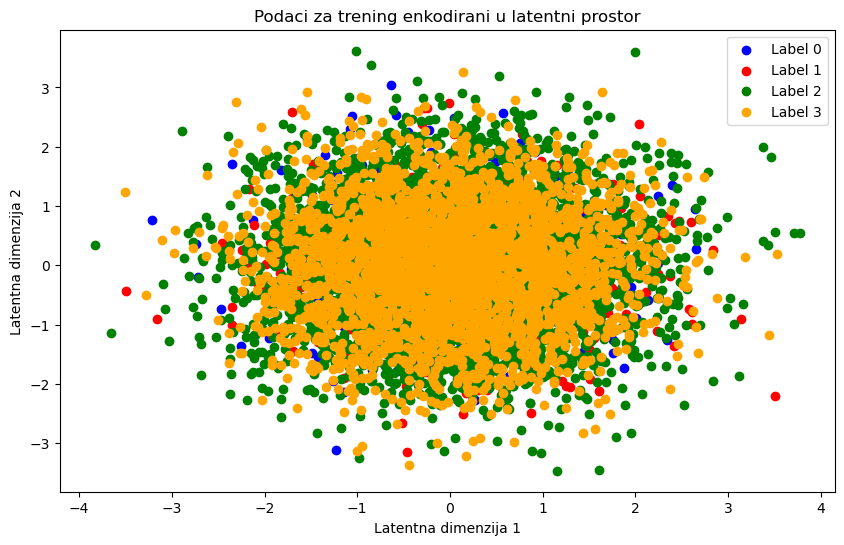

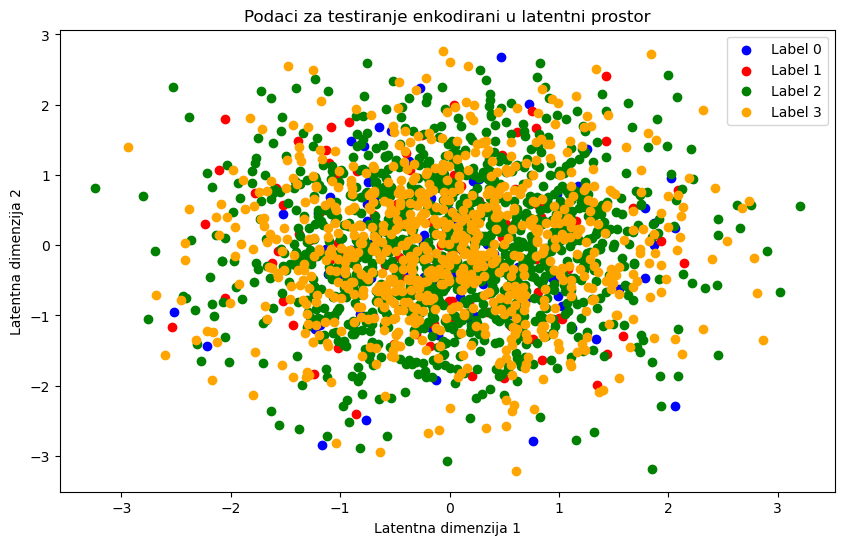

In [27]:
def plot_input_data(x_data, y_data):
    z_input = x_data
    unique_labels = np.unique(y_data)
    label_colors = ['blue', 'red', 'green', 'orange']
    
    for label in unique_labels:
        indices = np.where(y_data == label)[0]
        plt.scatter(z_input[indices, 0], z_input[indices, 1], c=label_colors[label], label=f'Label {label}')

    plt.xlabel("Latentna dimenzija 1")
    plt.ylabel("Latentna dimenzija 2")
    plt.legend()
    plt.show()
    
plt.figure(figsize=(10, 6))
plt.title("Podaci za trening enkodirani u latentni prostor")
plot_input_data(z_input, y_train)

plt.figure(figsize=(10, 6))
plt.title("Podaci za testiranje enkodirani u latentni prostor")
plot_input_data(z_test_input, y_test)

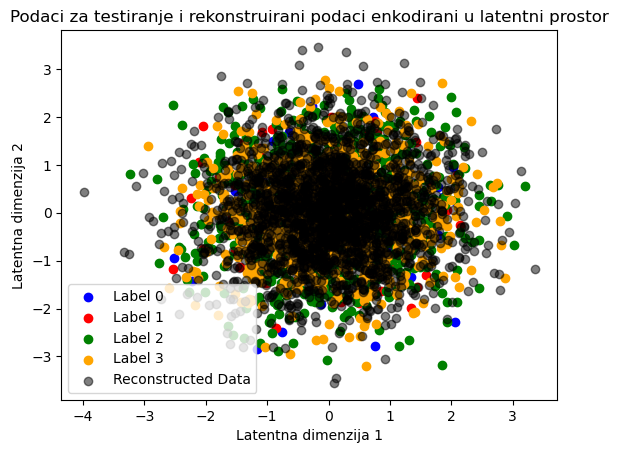

In [28]:
def plot_input_and_reconstructed_data(x_input_data, x_reconstructed, y_input_data):
    z_input = x_input_data
    recon_data_lsp = x_reconstructed
    
    unique_labels = np.unique(y_input_data)
    label_colors = ['blue', 'red', 'green', 'orange']
    
    for label in unique_labels:
        indices = np.where(y_input_data == label)[0]
        plt.scatter(z_input[indices, 0], z_input[indices, 1], c=label_colors[label], label=f'Label {label}')

    plt.scatter(recon_data_lsp[:, 0], recon_data_lsp[:, 1], c='black', alpha=0.5, label='Reconstructed Data')

    plt.xlabel("Latentna dimenzija 1")
    plt.ylabel("Latentna dimenzija 2")
    plt.title("Podaci za testiranje i rekonstruirani podaci enkodirani u latentni prostor")
    plt.legend()
    plt.show()

plot_input_and_reconstructed_data(z_test_input, reconstructed_z_test_encoded, y_test)


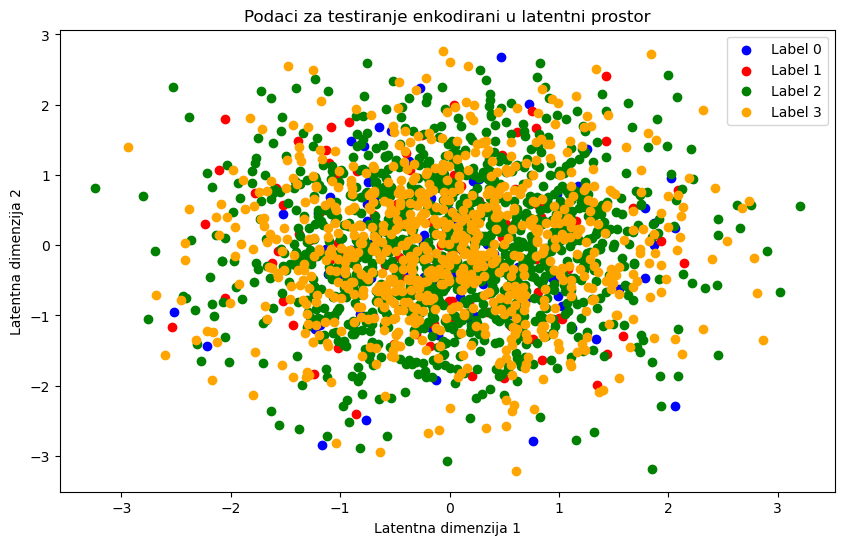

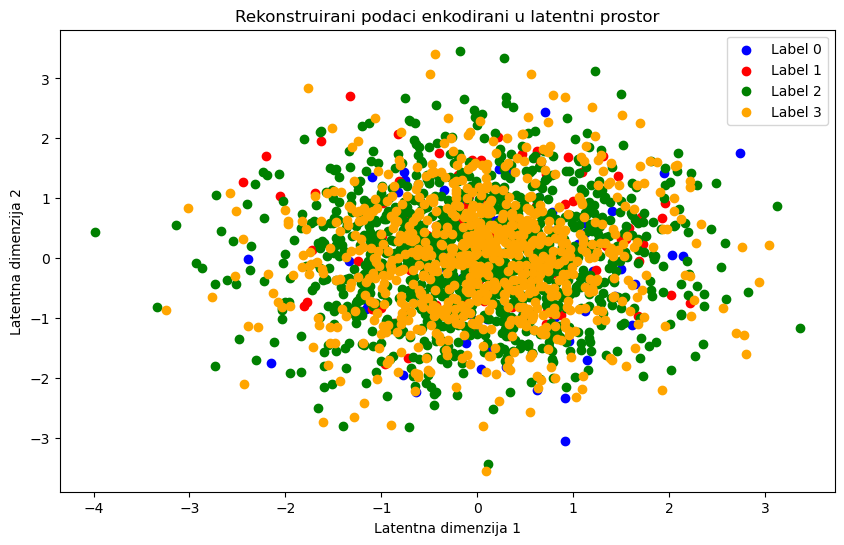

In [29]:
def plot_reconstructed_data(x_reconstructed, y_data):
    recon_data_lsp = x_reconstructed
    
    unique_labels = np.unique(y_data)
    label_colors = ['blue', 'red', 'green', 'orange']
    
    for label in unique_labels:
        indices = np.where(y_data == label)[0]
        plt.scatter(recon_data_lsp[indices, 0], recon_data_lsp[indices, 1], 
                    c=label_colors[label], label=f'Label {label}')

    plt.xlabel("Latentna dimenzija 1")
    plt.ylabel("Latentna dimenzija 2")
    plt.legend()
    plt.show()
    
plt.figure(figsize=(10, 6))
plt.title("Podaci za testiranje enkodirani u latentni prostor")
plot_input_data(z_test_input, y_test)

plt.figure(figsize=(10, 6))
plt.title("Rekonstruirani podaci enkodirani u latentni prostor")
plot_reconstructed_data(reconstructed_z_test_encoded, y_test)

1/1 [==============================] - 0s 16ms/step


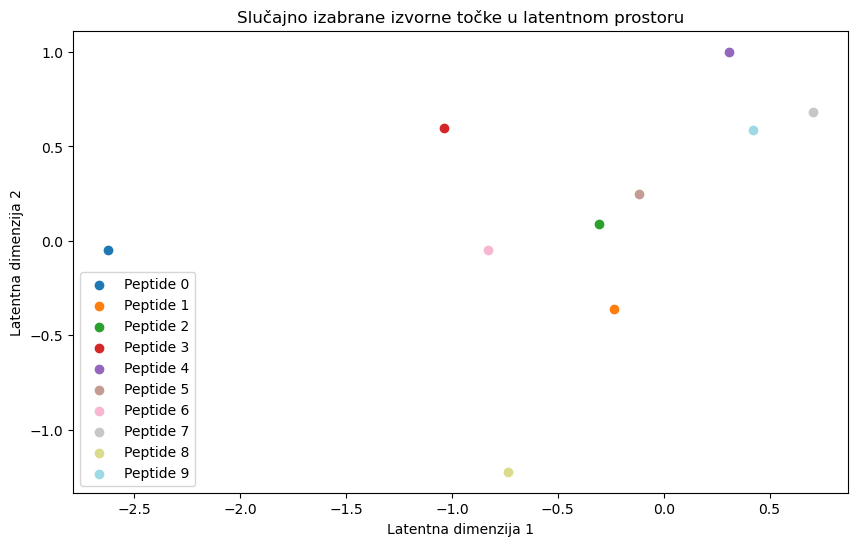

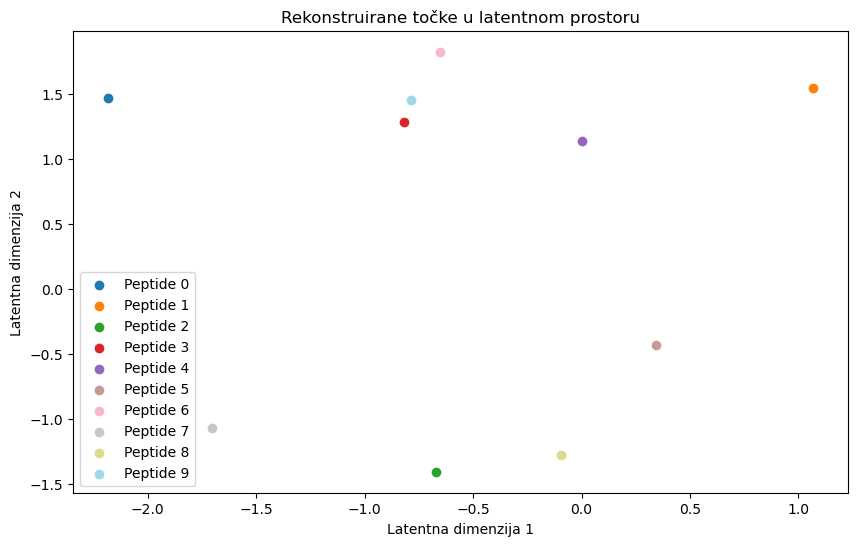

Udaljenost između svake pojedine točke i njoj pripadajuće rekonstruirane točke: 
 [5.4727173, 6.334735, 6.3136683, 6.4382586, 6.305743, 5.239723, 4.511011, 5.104633, 5.814873, 7.2518444] 

Prosječna udaljenost između izvornih i rekonstruiranih točaka:  5.87872085571289


In [30]:
selected_indices = np.random.choice(len(x_test), 10, replace=False)

selected_peptides = x_test[selected_indices]

_, _, encoded_selected_peptides = vae.encoder.predict(selected_peptides)
reconstructed_peptides = vae.decoder.predict(encoded_selected_peptides)
_, _, encoded_reconstructed_peptides = vae.encoder.predict(reconstructed_peptides)


def plot_selected_data(x_data):
    z_input = x_data
    num_peptides = z_input.shape[0]
    unique_colors = plt.cm.tab20(np.linspace(0, 1, num_peptides))

    for i in range(num_peptides):
        plt.scatter(z_input[i, 0], z_input[i, 1], color=unique_colors[i], label=f'Peptide {i}')

    plt.xlabel("Latentna dimenzija 1")
    plt.ylabel("Latentna dimenzija 2")
    plt.legend()
    plt.show()

    
def euclidean_distance(x, y):
    return np.sqrt(np.sum((x - y)**2))


plt.figure(figsize=(10, 6))
plt.title("Slučajno izabrane izvorne točke u latentnom prostoru")
plot_selected_data(encoded_selected_peptides)

plt.figure(figsize=(10, 6))
plt.title("Rekonstruirane točke u latentnom prostoru")
plot_selected_data(encoded_reconstructed_peptides)


distances = []

for i in range(10):
    dist = euclidean_distance(encoded_selected_peptides[i], encoded_reconstructed_peptides[i])
        
    distances.append(dist)

print("Udaljenost između svake pojedine točke i njoj pripadajuće rekonstruirane točke: \n", distances, "\n")
print("Prosječna udaljenost između izvornih i rekonstruiranih točaka: ", np.sum(distances)/10)

In [31]:
from Bio import pairwise2
from Bio.Seq import Seq

def calculate_sequence_similarity(seq1, seq2):
  
    seq1 = Seq(seq1)
    seq2 = Seq(seq2)

    alignments = pairwise2.align.globalxx(seq1, seq2)

    best_alignment = alignments[0]
    seq1_aligned, seq2_aligned, score, begin, end = best_alignment

    similarity = (score / max(len(seq1), len(seq2)))

    return similarity

similarities_train = []
similarities_test = []

for i in range(50):
    row_similarities_train = []
    row_similarities_test = []
    for j in range(50,101):
        sim_train = calculate_sequence_similarity(x_train_seq[i], x_train_seq[j])
        sim_test = calculate_sequence_similarity(x_test_seq[i], x_test_seq[j])
        row_similarities_train.append(sim_train)
        row_similarities_test.append(sim_test)
        
    similarities_train.append(row_similarities_train)
    similarities_test.append(row_similarities_test)
    
similarities_train = np.array(similarities_train)
similarities_test = np.array(similarities_test)

print(similarities_train)
print(similarities_test)

[[0.25581395 0.13953488 0.39534884 ... 0.39534884 0.18604651 0.34883721]
 [0.1025641  0.         0.12820513 ... 0.13157895 0.125      0.05263158]
 [0.20512821 0.28       0.23076923 ... 0.18421053 0.32       0.23684211]
 ...
 [0.33333333 0.21621622 0.35897436 ... 0.34210526 0.32432432 0.34210526]
 [0.33333333 0.17777778 0.26666667 ... 0.33333333 0.22222222 0.33333333]
 [0.07692308 0.25       0.15384615 ... 0.18421053 0.16666667 0.23684211]]
[[0.27272727 0.18604651 0.27906977 ... 0.27906977 0.20930233 0.30232558]
 [0.36363636 0.25581395 0.27906977 ... 0.3255814  0.1627907  0.18604651]
 [0.25       0.17241379 0.26666667 ... 0.14285714 0.3        0.2       ]
 ...
 [0.15909091 0.31034483 0.33333333 ... 0.26190476 0.28571429 0.14285714]
 [0.34090909 0.2972973  0.54054054 ... 0.28571429 0.24324324 0.2972973 ]
 [0.09090909 0.13793103 0.06666667 ... 0.0952381  0.17647059 0.2       ]]


In [32]:
distances_train = []
distances_test = []

for i in range(50):
    row_distances_train = []
    row_distances_test = []
    for j in range(50,101):
        dist_train = euclidean_distance(z_input[i], z_input[j])
        dist_test = euclidean_distance(z_test_input[i], z_test_input[j])
        row_distances_train.append(dist_train)
        row_distances_test.append(dist_test)
        
    distances_train.append(row_distances_train)
    distances_test.append(row_distances_test)
        
distances_train = np.array(distances_train)
distances_test = np.array(distances_test)

normalized_distances_train = scaler.fit_transform(distances_train)
normalized_distances_test = scaler.fit_transform(distances_test)

print(normalized_distances_train)
print(normalized_distances_test)

[[0.32770324 0.4518112  0.42720246 ... 0.17184848 0.56156325 0.566674  ]
 [0.5038022  0.49640715 0.33208203 ... 0.56905764 0.14200842 0.5849731 ]
 [0.24859059 0.01606607 0.11740696 ... 0.22635621 0.11837876 0.02971792]
 ...
 [0.24545288 0.5149338  0.37578654 ... 0.42407888 0.40324783 0.79516983]
 [0.7880404  0.44185424 0.16521657 ... 0.54113334 0.6616025  0.6686189 ]
 [0.         0.         0.23419464 ... 0.36683732 0.2122606  0.05080807]]
[[0.70982456 0.3830105  0.5626161  ... 0.57152486 0.23563868 0.77687204]
 [0.45212948 0.3065536  0.47188187 ... 0.49029624 0.5315121  0.9197986 ]
 [0.40389466 0.00851083 0.4650557  ... 0.1742605  0.9498009  0.5288979 ]
 ...
 [0.55636156 0.3720913  0.818004   ... 0.12505293 0.6230261  0.51372814]
 [0.51848435 0.16935337 0.23363137 ... 0.         0.4585672  0.5215256 ]
 [0.23252559 0.7220149  0.49680245 ... 0.35146248 0.4080544  0.3369627 ]]


In [33]:
from scipy.stats import spearmanr, kendalltau, pearsonr

correlation_train, p_value_train = spearmanr(similarities_train.flatten(), distances_train.flatten())
correlation_test, p_value_test = spearmanr(similarities_test.flatten(), distances_test.flatten())

print("Spearmanov koeficijent korelacije za skupove podataka za trening i testiranje: \n", correlation_train, correlation_test)
print("p-value:", p_value_train, p_value_test, "\n")

correlation_train, p_value_train = pearsonr(similarities_train.flatten(), distances_train.flatten())
correlation_test, p_value_test = pearsonr(similarities_test.flatten(), distances_test.flatten())

print("Pearsonov koeficijent korelacije za skupove podataka za trening i testiranje: \n", correlation_train, correlation_test)
print("p-value:", p_value_train, p_value_test, "\n")

correlation_train, p_value_train = kendalltau(similarities_train.flatten(), distances_train.flatten())
correlation_test, p_value_test = kendalltau(similarities_test.flatten(), distances_test.flatten())

print("Kendall tau koeficijent korelacije za skupove podataka za trening i testiranje: \n", correlation_train, correlation_test)
print("p-value:", p_value_train, p_value_test)

Spearmanov koeficijent korelacije za skupove podataka za trening i testiranje: 
 -0.005396348439750964 -0.027292621067533534
p-value: 0.7853370670891544 0.16826791830727791 

Pearsonov koeficijent korelacije za skupove podataka za trening i testiranje: 
 -0.015262407599392791 -0.03129064953805741
p-value: 0.44107404733499084 0.11417274160881052 

Kendall tau koeficijent korelacije za skupove podataka za trening i testiranje: 
 -0.003575813986544251 -0.018177683914917822
p-value: 0.7874601715405385 0.17084666798814085


66/66 [==============================] - 0s 1ms/step


C:\Anaconda\envs\autoencoders\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Anaconda\envs\autoencoders\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


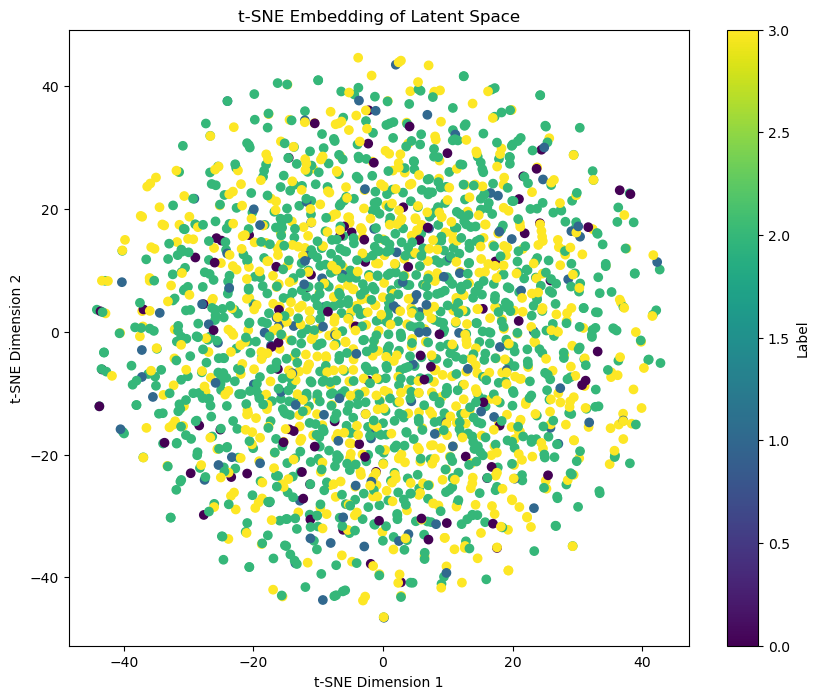

In [36]:
from sklearn.manifold import TSNE

def plot_tsne_latent_space(encoder, data, labels):
    _, _, latent_repr = encoder.predict(data)
    
    tsne = TSNE(n_components=2, random_state=42)
    tsne_results = tsne.fit_transform(latent_repr)

    plt.figure(figsize=(10, 8))
    plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=labels, cmap='viridis')
    plt.colorbar(label='Label')
    plt.title('t-SNE Embedding of Latent Space')
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    plt.show()

plot_tsne_latent_space(encoder, x_test, y_test)



In [35]:
print(z_input[0])
print(reconstructed_z_input[0])
print(reconstructed_z_encoded[0])

[ 0.54934716 -0.11256729 -0.6592046   1.8690995   0.03933267  0.09155027
 -0.09488022 -2.357847   -1.0160522   1.0497267   1.0795232  -1.2733942
  0.38569716 -0.6188869  -0.7376527  -0.9773259   0.77000594  0.88570374
 -0.39685518  0.6598546 ]
[[0.4784461]
 [0.4784461]
 [0.4784461]
 [0.4784461]
 [0.4784461]
 [0.4784461]
 [0.4784461]
 [0.4784461]
 [0.4784461]
 [0.4784461]
 [0.4784461]
 [0.4784461]
 [0.4784461]
 [0.4784461]
 [0.4784461]
 [0.4784461]
 [0.4784461]
 [0.4784461]
 [0.4784461]
 [0.4784461]
 [0.4784461]
 [0.4784461]
 [0.4784461]
 [0.4784461]
 [0.4784461]
 [0.4784461]
 [0.4784461]
 [0.4784461]
 [0.4784461]
 [0.4784461]
 [0.4784461]
 [0.4784461]
 [0.4784461]
 [0.4784461]
 [0.4784461]
 [0.4784461]
 [0.4784461]
 [0.4784461]
 [0.4784461]
 [0.4784461]
 [0.4784461]
 [0.4784461]
 [0.4784461]
 [0.4784461]
 [0.4784461]
 [0.4784461]
 [0.4784461]
 [0.4784461]
 [0.4784461]
 [0.4784461]
 [0.4784461]
 [0.4784461]
 [0.4784461]
 [0.4784461]
 [0.4784461]
 [0.4784461]
 [0.4784461]
 [0.4784461]
 [